# Store Sales kaggle competition

## Import libraries and loading raw data

### Importing the relevant libraries

In [1]:
import os
from pathlib import Path
import sys
# Dynamically add the parent directory of 'store_sales_DL' to the Python path
module_path = Path(os.getcwd()).parent  # Adjust based on the relative structure
if module_path not in sys.path:
    sys.path.append(str(module_path))
# For this practical example we will need the following libraries and modules
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import shapiro, kstest, anderson
import seaborn as sns
sns.set()
from pathlib import Path
from ydata_profiling import ProfileReport
from dotenv import load_dotenv
from store_sales_DL.config import PROCESSED_DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR
import gc
from typing import Sequence, Optional
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
print(tf.sysconfig.get_build_info())

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
# Load environment variables from .env file if it exists
load_dotenv()
%load_ext mypy_ipython

#Uncomment/comment the following line if you want to see/unsee the type checking results
#%mypy

2025-05-10 09:20:01.709659: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-10 09:20:02.125984: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-10 09:20:03.703256: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.


OrderedDict({'cpu_compiler': '/usr/lib/llvm-18/bin/clang', 'cuda_compute_capabilities': ['sm_60', 'sm_70', 'sm_80', 'sm_89', 'compute_90'], 'cuda_version': '12.5.1', 'cudnn_version': '9', 'is_cuda_build': True, 'is_rocm_build': False, 'is_tensorrt_build': False})
[]


E0000 00:00:1746858004.233640     506 cuda_executor.cc:1279] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1746858004.238424     506 gpu_device.cc:2340] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Utility functions

Using memory management since the variable management is not clean. Resetting DataFrames since we have raw, interim and processed CSV files. Which can be re-readed in code.

In [6]:
# Function to delete all DataFrame variables
def reset_all_dataframes(exclude: Optional[str] = None) -> None:
    """
    Deletes all pandas DataFrame variables in the current namespace except those in the exclude list.
    
    Parameters:
    - exclude (list): List of variable names to exclude from deletion.
    """
    if exclude is None:
        exclude = []
    
    # Get the list of all variables in the global namespace
    all_vars = list(globals().keys())
    
    # Exclude system variables, imported modules, and user-specified variables
    exclude += ['reset_all_dataframes', 'gc', 'pd', '__name__', '__doc__', '__package__', '__loader__', '__spec__', '__annotations__', '__builtins__', '__file__', '__cached__']
    
    # Delete only DataFrame variables except those in the exclude list
    for var in all_vars:
        if var not in exclude:
            obj = globals()[var]
            if isinstance(obj, pd.DataFrame):  # Check if the variable is a DataFrame
                del globals()[var]
    
    # Force garbage collection
    gc.collect()

Drop columns from dataframe to interim -> preprocessing purposes

In [7]:
def drop_columns(df: pd.DataFrame, columns_to_drop: list) -> pd.DataFrame:
    """
    Drops specified columns from a DataFrame in a structured way.

    Parameters:
    - df (pd.DataFrame): The DataFrame from which columns will be dropped.
    - columns_to_drop (list): List of column names to drop.

    Returns:
    - pd.DataFrame: A new DataFrame with the specified columns removed.
    """
    # Check if all columns to drop exist in the DataFrame
    missing_columns = [col for col in columns_to_drop if col not in df.columns]
    if missing_columns:
        print(f"Warning: The following columns are not in the DataFrame and will be ignored: {missing_columns}")
    
    # Drop the columns
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Return the updated DataFrame
    return df

### Loading the raw data and printing 


In [8]:

# Defining input paths
oil_raw_input_path: Path = RAW_DATA_DIR / "oil.csv"
holidays_events_raw_input_path: Path = RAW_DATA_DIR / "holidays_events.csv"
transactions_raw_input_path: Path = RAW_DATA_DIR / "transactions.csv"
stores_raw_input_path: Path = RAW_DATA_DIR / "stores.csv"
train_raw_input_path: Path = RAW_DATA_DIR / "train.csv"
test_raw_input_path: Path = RAW_DATA_DIR / "test.csv"
# Defining output paths
train_intermin_output_path: Path = INTERIM_DATA_DIR / "interim_train.csv"

# Load the data from a .csv and make a copy so that the initial file wont be affected
oil_df = pd.read_csv(oil_raw_input_path).copy()
holidays_events_df = pd.read_csv(holidays_events_raw_input_path).copy()
transactions_df = pd.read_csv(transactions_raw_input_path).copy()
stores_df = pd.read_csv(stores_raw_input_path).copy()
train_interim_df = pd.read_csv(train_raw_input_path).copy()
test_df = pd.read_csv(train_raw_input_path).copy()

# Let's explore the top 5 rows of the df
print("\nOil Raw Data")
display(oil_df.head())

print("\nHolidays Events")
display(holidays_events_df.head())

print("\nTransactions Raw Data")
display(transactions_df.head())

print("\nStores Data")
display(stores_df.head())

print("\nTrain raw Data")
display(train_interim_df.head())



Oil Raw Data


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20



Holidays Events


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False



Transactions Raw Data


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922



Stores Data


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4



Train raw Data


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


## Interim dataset
Process data so that the dataset is not yet finetuned for some specific ML model

### Start of interim dataset - joining dimensions to train data
Realized that holiday events cannot be joined to train without transformation

In [9]:

# Merge the datasets
train_merged_df = train_interim_df.copy()
# Assuming 'store_nbr' is the common column between train_interim_df and stores_df
train_merged_df = train_interim_df.merge(stores_df, on='store_nbr', how='left')

# Assuming 'date' is the common column between train_merged_df and oil_df
train_merged_df = train_merged_df.merge(oil_df, on='date', how='left')

# Assuming 'date' is the common column between train_merged_df and holidays_events_df
#train_merged_df = train_merged_df.merge(holidays_events_df, on='date', how='left')

# Assuming 'date' and 'store_nbr' are the common columns between train_merged_df and transactions_df
train_merged_df = train_merged_df.merge(transactions_df, on=['date', 'store_nbr'], how='left')

# Display the merged DataFrame
print("Merged Train Data")
#display(train_merged_df.head())

# Get the initial row count of train_interim_df
initial_row_count = train_interim_df.shape[0]
print("\nTrain data row count before merge")
print(initial_row_count)

# Get the initial row count of train_interim_df
train_row_count_after_merge = train_merged_df.shape[0]
print("\nTrain data row count after merge")
print(train_row_count_after_merge)

Merged Train Data

Train data row count before merge
3000888

Train data row count after merge
3000888


Seems like holidays_events_df has duplicate rows for specific dates and need to be explored more closely at this point. Othewise left join will duplicate train dataset rows which is unwanted.

### Interim dataset - explore holiday_events_df
How to transform?

Goal is now to process holiday event in a way that merging to train data set is possible without increasing row counts

In [10]:
holidays_events_df.head()

# Generate the profiling report
profile = ProfileReport(holidays_events_df, title="Holidays Events Profiling Report")

# Display the report in a Jupyter notebook
profile.to_notebook_iframe()

# Optionally, save the report to an HTML file
profile.to_file("holidays_events_profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 178.54it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Number of observations: 350
<br>
Date column distinct values: 312
<br>
Date column distinct (%): 89.1%


In [11]:
# Find duplicate dates
duplicate_dates = holidays_events_df[holidays_events_df.duplicated(subset='date', keep=False)]

# Display the rows with duplicate dates
print("Rows with duplicate dates:")
display(duplicate_dates)

Rows with duplicate dates:


,date,type,locale,locale_name,description,transferred
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False
10,2012-07-03,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False
11,2012-07-03,Holiday,Local,El Carmen,Cantonizacion de El Carmen,False
...,...,...,...,...,...,...
319,2017-07-03,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False
341,2017-12-08,Holiday,Local,Loja,Fundacion de Loja,False
342,2017-12-08,Transfer,Local,Quito,Traslado Fundacion de Quito,False
344,2017-12-22,Holiday,Local,Salinas,Cantonizacion de Salinas,False


From the dataframe above I assume that combination of date and locale_name could hold only unique values. Lets verify that.

In [12]:
# Find duplicate date and locale_name combinations
duplicate_combinations = holidays_events_df[holidays_events_df.duplicated(subset=['date', 'locale_name'], keep=False)]

# Display the rows with duplicate date and locale_name combinations
print("Rows with duplicate date and locale_name combinations:")
display(duplicate_combinations)

Rows with duplicate date and locale_name combinations:


,date,type,locale,locale_name,description,transferred
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
39,2012-12-31,Bridge,National,Ecuador,Puente Primer dia del ano,False
40,2012-12-31,Additional,National,Ecuador,Primer dia del ano-1,False
156,2014-12-26,Bridge,National,Ecuador,Puente Navidad,False
157,2014-12-26,Additional,National,Ecuador,Navidad+1,False
235,2016-05-01,Holiday,National,Ecuador,Dia del Trabajo,False
236,2016-05-01,Event,National,Ecuador,Terremoto Manabi+15,False
242,2016-05-07,Additional,National,Ecuador,Dia de la Madre-1,False
243,2016-05-07,Event,National,Ecuador,Terremoto Manabi+21,False


The combination of date and locale_name is not unique. Combination of date, type and locale_name are almost unique with one duplicate National event on Ecuador on 2016-05-08.


I want to check 2 things in this point:

1) What is transferred column?
<br>
 --> type: "Transfer" has 12 rows. transferred: "True" has 12 rows. This can be seen from the profiling report above.
2) Can we find counterpart key for locale_name in our training dataset?
<br>
 -->Stores data heads show that city and state field are available.

In [13]:
#1) What is transferred column?
# --> type: "Transfer" has 12 rows. transferred: "True" has 12 rows. 
# --> This can be seen from the profiling report above.

# Filter the DataFrame
filtered_df = holidays_events_df[(holidays_events_df['type'] == "Transfer") | (holidays_events_df['transferred'] == True)]

# Display the filtered DataFrame
print("Filtered DataFrame where type is 'Transfer' or transferred is 'True'")
display(filtered_df)

Filtered DataFrame where type is 'Transfer' or transferred is 'True'


,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True


My plan is to filter out transferred = "True" record since there is pair available for each records (which indicated when the holiday was actually celebrated).

In [14]:
#2) Can we find counterpart key for locale_name in our training dataset?
# -->Stores data heads show that city and state field are available.

# Merge the datasets on 'locale_name' and 'city'
merged_df = holidays_events_df.merge(stores_df, left_on='locale_name', right_on='city', how='left')

# Display the merged DataFrame
print("Merged DataFrame with Holidays Events and Stores Data")
display(merged_df.head())

# Filter rows where 'store_nbr' is null
store_nbr_nulls = merged_df[merged_df['store_nbr'].isnull()]

# Show the distribution of 'store_nbr' nulls between 'locale_name' values
null_distribution = store_nbr_nulls['locale'].value_counts()
print("Distribution of 'store_nbr' nulls between 'locale' values:")
print(null_distribution)

# Plot the distribution of 'store_nbr' nulls between 'locale_name' values
plt.figure(figsize=(12, 6))
sns.barplot(x=null_distribution.index, y=null_distribution.values)
plt.xticks(rotation=90)
plt.xlabel('Locale')
plt.ylabel('Number of Null Store Numbers')
plt.title('Distribution of Null Store Numbers between Locale Names')
plt.show()

Merged DataFrame with Holidays Events and Stores Data


,date,type_x,locale,locale_name,description,transferred,store_nbr,city,state,type_y,cluster
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,52.0,Manta,Manabi,A,11.0
1,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,53.0,Manta,Manabi,D,13.0
2,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,NaN,NaN,NaN,NaN,NaN
3,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,37.0,Cuenca,Azuay,D,2.0
4,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,39.0,Cuenca,Azuay,B,6.0


Distribution of 'store_nbr' nulls between 'locale' values:
locale
National    174
Regional     24
Name: count, dtype: int64


/tmp/ipykernel_662/903568457.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


No null values for "Local" Locale. City and Locale_name are keys for Holidays that are "Local" Locale.

Merged DataFrame with Holidays Events and Stores Data


,date,type_x,locale,locale_name,description,transferred,store_nbr,city,state,type_y,cluster
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,NaN,NaN,NaN,NaN,NaN
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,12.0,Latacunga,Cotopaxi,C,15.0
2,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,13.0,Latacunga,Cotopaxi,C,15.0
3,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,NaN,NaN,NaN,NaN,NaN
4,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,NaN,NaN,NaN,NaN,NaN


Distribution of 'store_nbr' nulls between 'locale' values:
locale
National    174
Local       140
Name: count, dtype: int64


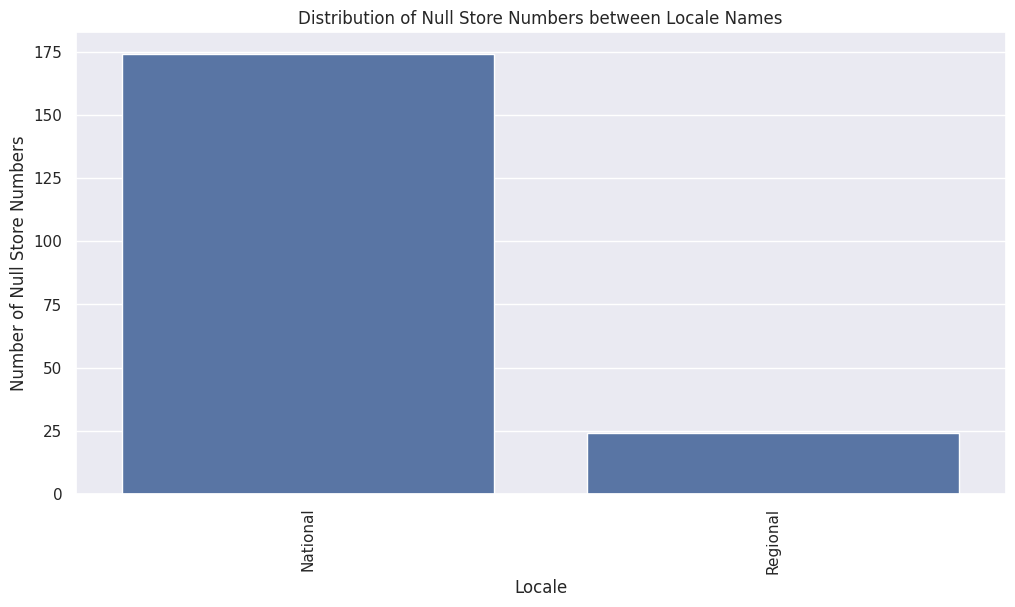

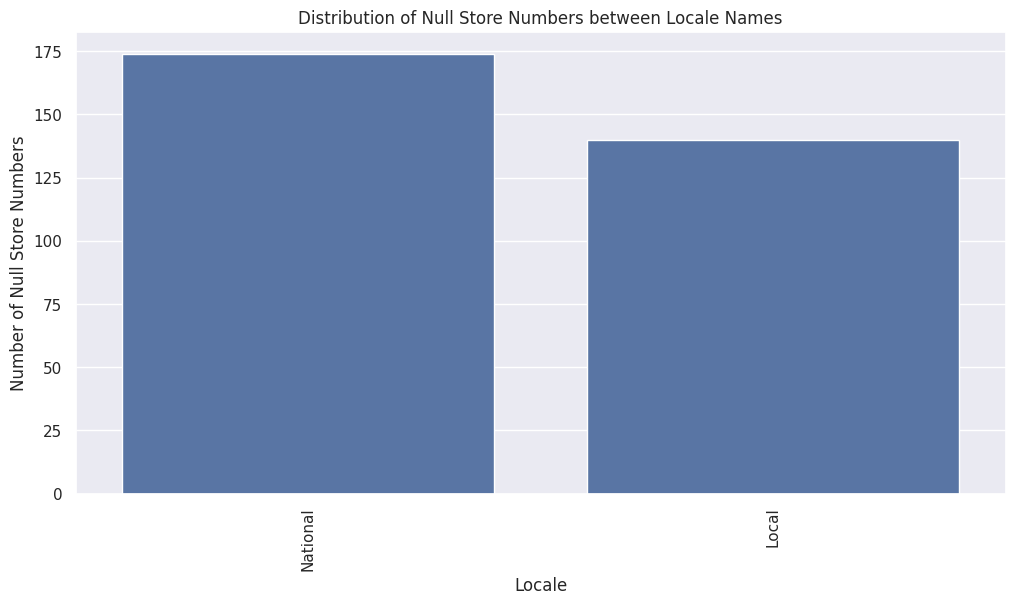

In [15]:
# Enable inline plotting
%matplotlib inline
# Merge the datasets on 'locale_name' and 'state'
merged_df = holidays_events_df.merge(stores_df, left_on='locale_name', right_on='state', how='left')

# Display the merged DataFrame
print("Merged DataFrame with Holidays Events and Stores Data")
display(merged_df.head())

# Filter rows where 'store_nbr' is null
store_nbr_nulls = merged_df[merged_df['store_nbr'].isnull()]

# Show the distribution of 'store_nbr' nulls between 'locale_name' values
null_distribution = store_nbr_nulls['locale'].value_counts()
print("Distribution of 'store_nbr' nulls between 'locale' values:")
print(null_distribution)

# Plot the distribution of 'store_nbr' nulls between 'locale_name' values
plt.figure(figsize=(12, 6))
sns.barplot(x=null_distribution.index, y=null_distribution.values)
plt.xticks(rotation=90)
plt.xlabel('Locale')
plt.ylabel('Number of Null Store Numbers')
plt.title('Distribution of Null Store Numbers between Locale Names')
plt.show()

No null values for "Regional" Locale. State and Locale_name are keys for Holidays that are "Regional" Locale.

In [16]:
# Filter rows where 'locale' is "National"
national_holidays_df = holidays_events_df[holidays_events_df['locale'] == "National"]

# Display the filtered DataFrame
print("Holiday Events with Locale = 'National'")
display(national_holidays_df)

Holiday Events with Locale = 'National'


,date,type,locale,locale_name,description,transferred
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


Stores data is for Ecuador. Therefore natinal events we should use date column as a key since the event will effect on every city and state.

### Interim dataset - transform holiday_events
Implementing transform

Now lets prepare holidays_events data to merge it to training data set. 

1) Change granularity to event + city based instead of event based. In the other words, convert National and regional events to each related cities. This will increase row amount.

2) My plan is to filter out transferred = True records since those are event dates that were rescheduled. I might need to double check later on if there rows could have significance when predicting store sales.

3) I want to make separate feature (each type gets its own column) for each type of events. At this point I will create separate dataframes for each type and then I should be able to merge all of these dataframes to trains dataset with same join logic.

In [17]:
#1

# Create a new DataFrame with unique combinations of 'city' and 'state'
unique_city_state_df = stores_df.drop_duplicates(subset=['city', 'state'])

# Display the new DataFrame
print("DataFrame with unique city and state combinations")
display(unique_city_state_df)
print(unique_city_state_df.shape[0])

DataFrame with unique city and state combinations


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
10,11,Cayambe,Pichincha,B,6
11,12,Latacunga,Cotopaxi,C,15
13,14,Riobamba,Chimborazo,C,7
14,15,Ibarra,Imbabura,C,15
18,19,Guaranda,Bolivar,C,15
21,22,Puyo,Pastaza,C,7
22,23,Ambato,Tungurahua,D,9
23,24,Guayaquil,Guayas,D,1


22


In [18]:
# Filter holidays_events_df for 'National', 'Regional', and 'Local' locales
national_holidays_df = holidays_events_df[holidays_events_df['locale'] == "National"]
regional_holidays_df = holidays_events_df[holidays_events_df['locale'] == "Regional"]
local_holidays_df = holidays_events_df[holidays_events_df['locale'] == "Local"]

# Merge 'National' holidays with all rows in unique_city_state_df (cross join)
national_merged_df = national_holidays_df.assign(key=1).merge(unique_city_state_df.assign(key=1), on='key').drop('key', axis=1)

# Merge 'Regional' holidays with unique_city_state_df on 'state' and 'locale_name'
regional_merged_df = regional_holidays_df.merge(unique_city_state_df, left_on='locale_name', right_on='state', how='left')

# Merge 'Local' holidays with unique_city_state_df on 'city' and 'locale_name'
local_merged_df = local_holidays_df.merge(unique_city_state_df, left_on='locale_name', right_on='city', how='left')

# Concatenate the three merged DataFrames
holidays_per_city_df = pd.concat([national_merged_df, regional_merged_df, local_merged_df], ignore_index=True)

# Drop the specified columns
holidays_per_city_df.drop(columns=['store_nbr', 'type_y', 'cluster'], inplace=True)
# Rename 'type_x' to 'type'
holidays_per_city_df.rename(columns={'type_x': 'type'}, inplace=True)
# Display the final merged DataFrame
print("Final Merged DataFrame")
display(holidays_per_city_df)

Final Merged DataFrame


,date,type,locale,locale_name,description,transferred,city,state
0,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Quito,Pichincha
1,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Santo Domingo,Santo Domingo de los Tsachilas
2,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Cayambe,Pichincha
3,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Latacunga,Cotopaxi
4,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Riobamba,Chimborazo
...,...,...,...,...,...,...,...,...
3999,2017-12-05,Additional,Local,Quito,Fundacion de Quito-1,False,Quito,Pichincha
4000,2017-12-06,Holiday,Local,Quito,Fundacion de Quito,True,Quito,Pichincha
4001,2017-12-08,Holiday,Local,Loja,Fundacion de Loja,False,Loja,Loja
4002,2017-12-08,Transfer,Local,Quito,Traslado Fundacion de Quito,False,Quito,Pichincha


In [19]:
#Validation

events_to_check = [
    {"date": "2012-06-25", "description": "Fundacion de Machala"}, #Local
    {"date": "2013-06-25", "description": "Provincializacion de Imbabura"}, #Regional
    {"date": "2016-05-08", "description": "Dia de la Madre"} #National
]

# Check and display the events
for event in events_to_check:
    event_df = holidays_per_city_df[(holidays_per_city_df['date'] == event['date']) & (holidays_per_city_df['description'] == event['description'])]
    print(f"Event: {event['description']} on {event['date']}")
    display(event_df)
    print(event_df.shape[0])

Event: Fundacion de Machala on 2012-06-25


,date,type,locale,locale_name,description,transferred,city,state
3859,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False,Machala,El Oro


1
Event: Provincializacion de Imbabura on 2013-06-25


,date,type,locale,locale_name,description,transferred,city,state
3833,2013-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False,Ibarra,Imbabura


1
Event: Dia de la Madre on 2016-05-08


,date,type,locale,locale_name,description,transferred,city,state
2772,2016-05-08,Event,National,Ecuador,Dia de la Madre,False,Quito,Pichincha
2773,2016-05-08,Event,National,Ecuador,Dia de la Madre,False,Santo Domingo,Santo Domingo de los Tsachilas
2774,2016-05-08,Event,National,Ecuador,Dia de la Madre,False,Cayambe,Pichincha
2775,2016-05-08,Event,National,Ecuador,Dia de la Madre,False,Latacunga,Cotopaxi
2776,2016-05-08,Event,National,Ecuador,Dia de la Madre,False,Riobamba,Chimborazo
2777,2016-05-08,Event,National,Ecuador,Dia de la Madre,False,Ibarra,Imbabura
2778,2016-05-08,Event,National,Ecuador,Dia de la Madre,False,Guaranda,Bolivar
2779,2016-05-08,Event,National,Ecuador,Dia de la Madre,False,Puyo,Pastaza
2780,2016-05-08,Event,National,Ecuador,Dia de la Madre,False,Ambato,Tungurahua
2781,2016-05-08,Event,National,Ecuador,Dia de la Madre,False,Guayaquil,Guayas


22


Now we have event + city level granularity. Next:

1) Save holidays_events interim dataset (before filter and split)
2) Filter out transferred = True
3) Remove duplicates (date, type, city combinations)
--> Trying this tactic for now. It could be wise to calculate amount of events instead of removing duplicates.
4) Split dataset to event type dataframes
5) merge each dataframe to training data

In [20]:
#1) Save holidays_events interim dataset (before filter and split)
# Define the output path
holidays_events_intermin_output_path: Path = INTERIM_DATA_DIR / "holidays_events_per_city.csv"

# Save the DataFrame to the specified path
holidays_per_city_df.to_csv(holidays_events_intermin_output_path, index=False)


In [21]:
#2) Filter out transferred = True
# Filter out rows where 'transferred' is True
holidays_per_city_without_transferred_df = holidays_per_city_df[holidays_per_city_df['transferred'] != True]

# Display the filtered DataFrame
print("Filtered Holidays Events DataFrame (transferred != True)")
display(holidays_per_city_without_transferred_df)
print("Rows before filtering:")
print(holidays_per_city_df.shape[0])

Filtered Holidays Events DataFrame (transferred != True)


,date,type,locale,locale_name,description,transferred,city,state
0,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Quito,Pichincha
1,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Santo Domingo,Santo Domingo de los Tsachilas
2,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Cayambe,Pichincha
3,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Latacunga,Cotopaxi
4,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Riobamba,Chimborazo
...,...,...,...,...,...,...,...,...
3998,2017-11-12,Holiday,Local,Ambato,Independencia de Ambato,False,Ambato,Tungurahua
3999,2017-12-05,Additional,Local,Quito,Fundacion de Quito-1,False,Quito,Pichincha
4001,2017-12-08,Holiday,Local,Loja,Fundacion de Loja,False,Loja,Loja
4002,2017-12-08,Transfer,Local,Quito,Traslado Fundacion de Quito,False,Quito,Pichincha


Rows before filtering:
4004


In [22]:
#3) Remove duplicates (date, type, city combinations)
#--> Trying this tactic for now. It could be wise to calculate amount of events instead of removing duplicates.

# Find duplicates of the combination of 'date', 'type', and 'city'
duplicates_df = holidays_per_city_without_transferred_df[holidays_per_city_without_transferred_df.duplicated(subset=['date', 'type', 'city'], keep=False)]

# Display the duplicates
print("Duplicates of date, type, and city combination:")
display(duplicates_df)
print(duplicates_df.shape[0])

Duplicates of date, type, and city combination:


,date,type,locale,locale_name,description,transferred,city,state
2750,2016-05-08,Event,National,Ecuador,Terremoto Manabi+22,False,Quito,Pichincha
2751,2016-05-08,Event,National,Ecuador,Terremoto Manabi+22,False,Santo Domingo,Santo Domingo de los Tsachilas
2752,2016-05-08,Event,National,Ecuador,Terremoto Manabi+22,False,Cayambe,Pichincha
2753,2016-05-08,Event,National,Ecuador,Terremoto Manabi+22,False,Latacunga,Cotopaxi
2754,2016-05-08,Event,National,Ecuador,Terremoto Manabi+22,False,Riobamba,Chimborazo
2755,2016-05-08,Event,National,Ecuador,Terremoto Manabi+22,False,Ibarra,Imbabura
2756,2016-05-08,Event,National,Ecuador,Terremoto Manabi+22,False,Guaranda,Bolivar
2757,2016-05-08,Event,National,Ecuador,Terremoto Manabi+22,False,Puyo,Pastaza
2758,2016-05-08,Event,National,Ecuador,Terremoto Manabi+22,False,Ambato,Tungurahua
2759,2016-05-08,Event,National,Ecuador,Terremoto Manabi+22,False,Guayaquil,Guayas


46


In [23]:
#3) Remove duplicates (date, type, city combinations)
#--> Trying this tactic for now. It could be wise to calculate amount of events instead of removing duplicates.

# Remove duplicates based on 'date', 'type', and 'city' while keeping all columns
unique_holidays_per_city_df = holidays_per_city_without_transferred_df.drop_duplicates(subset=['date', 'type', 'city'])

# Display the DataFrame with unique values
print("DataFrame with unique values based on 'date', 'type', and 'city':")
display(unique_holidays_per_city_df)

DataFrame with unique values based on 'date', 'type', and 'city':


,date,type,locale,locale_name,description,transferred,city,state
0,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Quito,Pichincha
1,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Santo Domingo,Santo Domingo de los Tsachilas
2,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Cayambe,Pichincha
3,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Latacunga,Cotopaxi
4,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Riobamba,Chimborazo
...,...,...,...,...,...,...,...,...
3998,2017-11-12,Holiday,Local,Ambato,Independencia de Ambato,False,Ambato,Tungurahua
3999,2017-12-05,Additional,Local,Quito,Fundacion de Quito-1,False,Quito,Pichincha
4001,2017-12-08,Holiday,Local,Loja,Fundacion de Loja,False,Loja,Loja
4002,2017-12-08,Transfer,Local,Quito,Traslado Fundacion de Quito,False,Quito,Pichincha


In [24]:
# Find duplicates of the combination of 'date', 'type', and 'city'
duplicates_df = unique_holidays_per_city_df[unique_holidays_per_city_df.duplicated(subset=['date', 'type', 'city'], keep=False)]

# Display the duplicates
print("Duplicates of date, type, and city combination:")
display(duplicates_df) #should be 0
print(duplicates_df.shape[0]) #should be 0

Duplicates of date, type, and city combination:


,date,type,locale,locale_name,description,transferred,city,state


0


In [25]:
#4) Split dataset to event type dataframes
# Create DataFrames for each type
holiday_df = unique_holidays_per_city_df[unique_holidays_per_city_df['type'] == "Holiday"]
event_df = unique_holidays_per_city_df[unique_holidays_per_city_df['type'] == "Event"]
additional_df = unique_holidays_per_city_df[unique_holidays_per_city_df['type'] == "Additional"]
transfer_df = unique_holidays_per_city_df[unique_holidays_per_city_df['type'] == "Transfer"]
bridge_df = unique_holidays_per_city_df[unique_holidays_per_city_df['type'] == "Bridge"]

# Display the DataFrames
print("Holiday DataFrame")
display(holiday_df)
print(holiday_df.shape[0])

print("\nEvent DataFrame")
display(event_df)
print(event_df.shape[0])

print("\nAdditional DataFrame")
display(additional_df)
print(additional_df.shape[0])

print("\nTransfer DataFrame")
display(transfer_df)
print(transfer_df.shape[0])

print("\nBridge DataFrame")
display(bridge_df)
print(bridge_df.shape[0])

Holiday DataFrame


,date,type,locale,locale_name,description,transferred,city,state
0,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Quito,Pichincha
1,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Santo Domingo,Santo Domingo de los Tsachilas
2,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Cayambe,Pichincha
3,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Latacunga,Cotopaxi
4,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,Riobamba,Chimborazo
...,...,...,...,...,...,...,...,...
3996,2017-11-10,Holiday,Local,Guaranda,Independencia de Guaranda,False,Guaranda,Bolivar
3997,2017-11-11,Holiday,Local,Latacunga,Independencia de Latacunga,False,Latacunga,Cotopaxi
3998,2017-11-12,Holiday,Local,Ambato,Independencia de Ambato,False,Ambato,Tungurahua
4001,2017-12-08,Holiday,Local,Loja,Fundacion de Loja,False,Loja,Loja


1300

Event DataFrame


,date,type,locale,locale_name,description,transferred,city,state
484,2013-05-12,Event,National,Ecuador,Dia de la Madre,False,Quito,Pichincha
485,2013-05-12,Event,National,Ecuador,Dia de la Madre,False,Santo Domingo,Santo Domingo de los Tsachilas
486,2013-05-12,Event,National,Ecuador,Dia de la Madre,False,Cayambe,Pichincha
487,2013-05-12,Event,National,Ecuador,Dia de la Madre,False,Latacunga,Cotopaxi
488,2013-05-12,Event,National,Ecuador,Dia de la Madre,False,Riobamba,Chimborazo
...,...,...,...,...,...,...,...,...
3537,2017-05-14,Event,National,Ecuador,Dia de la Madre,False,Loja,Loja
3538,2017-05-14,Event,National,Ecuador,Dia de la Madre,False,Machala,El Oro
3539,2017-05-14,Event,National,Ecuador,Dia de la Madre,False,Esmeraldas,Esmeraldas
3540,2017-05-14,Event,National,Ecuador,Dia de la Madre,False,Manta,Manabi


1210

Additional DataFrame


,date,type,locale,locale_name,description,transferred,city,state
110,2012-12-21,Additional,National,Ecuador,Navidad-4,False,Quito,Pichincha
111,2012-12-21,Additional,National,Ecuador,Navidad-4,False,Santo Domingo,Santo Domingo de los Tsachilas
112,2012-12-21,Additional,National,Ecuador,Navidad-4,False,Cayambe,Pichincha
113,2012-12-21,Additional,National,Ecuador,Navidad-4,False,Latacunga,Cotopaxi
114,2012-12-21,Additional,National,Ecuador,Navidad-4,False,Riobamba,Chimborazo
...,...,...,...,...,...,...,...,...
3961,2016-07-24,Additional,Local,Guayaquil,Fundacion de Guayaquil-1,False,Guayaquil,Guayas
3972,2016-12-05,Additional,Local,Quito,Fundacion de Quito-1,False,Quito,Pichincha
3988,2017-07-24,Additional,Local,Guayaquil,Fundacion de Guayaquil-1,False,Guayaquil,Guayas
3989,2017-07-25,Additional,Local,Guayaquil,Fundacion de Guayaquil,False,Guayaquil,Guayas


891

Transfer DataFrame


,date,type,locale,locale_name,description,transferred,city,state
44,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,Quito,Pichincha
45,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,Santo Domingo,Santo Domingo de los Tsachilas
46,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,Cayambe,Pichincha
47,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,Latacunga,Cotopaxi
48,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,Riobamba,Chimborazo
...,...,...,...,...,...,...,...,...
3629,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False,El Carmen,Manabi
3962,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False,Guayaquil,Guayas
3978,2017-04-13,Transfer,Local,Cuenca,Fundacion de Cuenca,False,Cuenca,Azuay
3994,2017-09-29,Transfer,Local,Ibarra,Fundacion de Ibarra,False,Ibarra,Imbabura


180

Bridge DataFrame


,date,type,locale,locale_name,description,transferred,city,state
176,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False,Quito,Pichincha
177,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False,Santo Domingo,Santo Domingo de los Tsachilas
178,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False,Cayambe,Pichincha
179,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False,Latacunga,Cotopaxi
180,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False,Riobamba,Chimborazo
...,...,...,...,...,...,...,...,...
3141,2016-11-04,Bridge,National,Ecuador,Puente Dia de Difuntos,False,Loja,Loja
3142,2016-11-04,Bridge,National,Ecuador,Puente Dia de Difuntos,False,Machala,El Oro
3143,2016-11-04,Bridge,National,Ecuador,Puente Dia de Difuntos,False,Esmeraldas,Esmeraldas
3144,2016-11-04,Bridge,National,Ecuador,Puente Dia de Difuntos,False,Manta,Manabi


110


### Interim dataset - merge holiday_events to train (DRAFT ONLY BUT NOT USED YET IN HERE)
Finally merged holiday events to train data

In [26]:
# Create the new columns
holiday_df['is_holiday'] = holiday_df['description'].notnull().astype(int)
event_df['is_event'] = event_df['description'].notnull().astype(int)
additional_df['is_additional'] = additional_df['description'].notnull().astype(int)
transfer_df['is_transfer'] = transfer_df['description'].notnull().astype(int)
bridge_df['is_bridge'] = bridge_df['description'].notnull().astype(int)

/tmp/ipykernel_662/2689051159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holiday_df['is_holiday'] = holiday_df['description'].notnull().astype(int)
/tmp/ipykernel_662/2689051159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_df['is_event'] = event_df['description'].notnull().astype(int)
/tmp/ipykernel_662/2689051159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [27]:
# Define the output paths
holiday_output_path = INTERIM_DATA_DIR / "holidays_holiday_df.csv"
event_output_path = INTERIM_DATA_DIR / "holidays_event_df.csv"
additional_output_path = INTERIM_DATA_DIR / "holidays_additional_df.csv"
transfer_output_path = INTERIM_DATA_DIR / "holidays_transfer_df.csv"
bridge_output_path = INTERIM_DATA_DIR / "holidays_bridge_df.csv"

# Save each DataFrame to the specified path
holiday_df.to_csv(holiday_output_path, index=False)
event_df.to_csv(event_output_path, index=False)
additional_df.to_csv(additional_output_path, index=False)
transfer_df.to_csv(transfer_output_path, index=False)
bridge_df.to_csv(bridge_output_path, index=False)

print(f"DataFrames saved to {INTERIM_DATA_DIR}")

DataFrames saved to /home/user/Downloads/venvs/store_sales_DL/src/store-sales-DL/data/interim


In [28]:
# Select only the necessary columns for merging
holiday_df = holiday_df[['date', 'city', 'is_holiday']]
event_df = event_df[['date', 'city', 'is_event']]
additional_df = additional_df[['date', 'city', 'is_additional']]
transfer_df = transfer_df[['date', 'city', 'is_transfer']]
bridge_df = bridge_df[['date', 'city', 'is_bridge']]

# Make a copy of train_merged_df
train_merged_with_events_df = train_merged_df.copy()
# Display the final merged DataFrame
print("Merged Train DataFrame before merging events to it")
display(train_merged_df)
# Merge each DataFrame with train_merged_with_events_df
train_merged_with_events_df = train_merged_with_events_df.merge(holiday_df, on=['date', 'city'], how='left')
train_merged_with_events_df = train_merged_with_events_df.merge(event_df, on=['date', 'city'], how='left')
train_merged_with_events_df = train_merged_with_events_df.merge(additional_df, on=['date', 'city'], how='left')
train_merged_with_events_df = train_merged_with_events_df.merge(transfer_df, on=['date', 'city'], how='left')
train_merged_with_events_df = train_merged_with_events_df.merge(bridge_df, on=['date', 'city'], how='left')

# Fill NaN values with 0 (since missing values mean the event did not occur)
train_merged_with_events_df[['is_holiday', 'is_event', 'is_additional', 'is_transfer', 'is_bridge']] = train_merged_with_events_df[['is_holiday', 'is_event', 'is_additional', 'is_transfer', 'is_bridge']].fillna(0)

# Display the final merged DataFrame
print("Final Merged Train DataFrame with Events")
display(train_merged_with_events_df)

Merged Train DataFrame before merging events to it


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,2155.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,2155.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,2155.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,2155.0


Final Merged Train DataFrame with Events


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,is_holiday,is_event,is_additional,is_transfer,is_bridge
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,NaN,NaN,1.0,0.0,0.0,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,NaN,NaN,1.0,0.0,0.0,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,NaN,NaN,1.0,0.0,0.0,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,NaN,NaN,1.0,0.0,0.0,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,NaN,NaN,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,2155.0,0.0,0.0,0.0,0.0,0.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,2155.0,0.0,0.0,0.0,0.0,0.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,2155.0,0.0,0.0,0.0,0.0,0.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,2155.0,0.0,0.0,0.0,0.0,0.0


Output record to csvs. Same day and city might have multiple events with different type. I decided to use 5 csv and 5 left joins to handle these case. It could be 1 csv and 5 left join with extra logic as well (at least for this feature engineering strategy)

### Interim dataset - Feature engineering (creating new features)

Store data one-hot encoding

In [29]:
# Load the data
stores_new_columns_df = stores_df.copy()

# One-hot encode the 'city', 'state', 'type', and 'cluster' columns with 0 and 1
stores_encoded_df = pd.get_dummies(stores_new_columns_df, columns=['city', 'state', 'type'], drop_first=True)

# Convert any boolean columns to integers (0 and 1)
stores_encoded_df = stores_encoded_df.astype(int)

# Drop the 'store_nbr' column from the one-hot encoded DataFrame to avoid duplication
stores_encoded_df = stores_encoded_df.drop(columns=['store_nbr'])

# Concatenate the original columns with the one-hot encoded columns
stores_final_df = pd.concat([stores_df, stores_encoded_df], axis=1)

# Display the final DataFrame
print("Stores DataFrame with Initial and One-hot Encoded Columns")
display(stores_final_df)

# Define the output path
stores_encoded_output_path = INTERIM_DATA_DIR / "stores_encoded_df.csv"

# Save the final DataFrame to the specified path
stores_final_df.to_csv(stores_encoded_output_path, index=False)

print(f"DataFrame saved to {stores_encoded_output_path}")


Stores DataFrame with Initial and One-hot Encoded Columns


,store_nbr,city,state,type,cluster,cluster,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,...,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,type_B,type_C,type_D,type_E
0,1,Quito,Pichincha,D,13,13,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,2,Quito,Pichincha,D,13,13,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,3,Quito,Pichincha,D,8,8,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,4,Quito,Pichincha,D,9,9,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,4,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
5,6,Quito,Pichincha,D,13,13,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
6,7,Quito,Pichincha,D,8,8,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
7,8,Quito,Pichincha,D,8,8,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
8,9,Quito,Pichincha,B,6,6,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
9,10,Quito,Pichincha,C,15,15,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


DataFrame saved to /home/user/Downloads/venvs/store_sales_DL/src/store-sales-DL/data/interim/stores_encoded_df.csv


Oil prices enrichment

Filling nulls with previous oil price (or next one if the first record is null)

Same for dates that are missing


In [30]:
# Make a copy of the original DataFrame
oil_filled_df = oil_df.copy()

# Ensure the 'date' column is in datetime format
oil_filled_df['date'] = pd.to_datetime(oil_filled_df['date'])

# Create a date range from 2013-01-01 to 2017-08-31
date_range = pd.date_range(start='2013-01-01', end='2017-08-31')

# Reindex the DataFrame to include all dates in the date range
oil_filled_df = oil_filled_df.set_index('date').reindex(date_range).rename_axis('date').reset_index()

# Iterate through the DataFrame to fill missing values
for i in range(len(oil_filled_df)):
    if pd.isnull(oil_filled_df.loc[i, 'dcoilwtico']):
        # Try to use the previous row's value
        if i > 0 and not pd.isnull(oil_filled_df.loc[i - 1, 'dcoilwtico']):
            oil_filled_df.loc[i, 'dcoilwtico'] = oil_filled_df.loc[i - 1, 'dcoilwtico']
        # If the previous row's value is not available, use the next row's value
        elif i < len(oil_filled_df) - 1 and not pd.isnull(oil_filled_df.loc[i + 1, 'dcoilwtico']):
            oil_filled_df.loc[i, 'dcoilwtico'] = oil_filled_df.loc[i + 1, 'dcoilwtico']

# Define the output path
oil_filled_output_path = INTERIM_DATA_DIR / "oil_filled_dates_and_nulls.csv"

# Save the final DataFrame to the specified path
oil_filled_df.to_csv(oil_filled_output_path, index=False)

print(f"DataFrame saved to {oil_filled_output_path}")

DataFrame saved to /home/user/Downloads/venvs/store_sales_DL/src/store-sales-DL/data/interim/oil_filled_dates_and_nulls.csv


One-hot encoding for product family

Checking first if train and test datasets have exactly the same families (family data is in fact datasets, no all inclusive dimensional dataset delivered)

In [31]:
# Load the train.csv data
train_df_copy = train_interim_df.copy()
test_df_copy = test_df.copy()

# Get the unique family values from both datasets
train_families = set(train_df_copy['family'].unique())
test_families = set(test_df_copy['family'].unique())

# Check if the family values are the same
if train_families == test_families:
    print("Both train.csv and test.csv have the same family values.")
else:
    print("The family values differ between train.csv and test.csv.")
    print("Families in train.csv but not in test.csv:", train_families - test_families)
    print("Families in test.csv but not in train.csv:", test_families - train_families)

# Take the unique values of the 'family' column and drop all other columns
unique_family_df = train_df_copy[['family']].drop_duplicates()

# Print the number of distinct families
print(f"Number of distinct families: {len(unique_family_df)}")

# Print the distinct family names
print("Distinct families:")
print(unique_family_df['family'].values)

# Perform one-hot encoding for the 'family' column and drop the first column to avoid multicollinearity
family_one_hot_encoded = pd.get_dummies(unique_family_df, columns=['family'], drop_first=True)

# Convert the one-hot encoded values to integers (0 and 1)
family_one_hot_encoded = family_one_hot_encoded.astype(int)

# Include the original 'family' column in the one-hot encoded DataFrame
family_encoded_df = pd.concat([unique_family_df.reset_index(drop=True), family_one_hot_encoded], axis=1)

# Verify the one-hot encoding
print("One-hot encoded DataFrame with original 'family' column:")
print(family_encoded_df.head())

# Define the output path
INTERIM_DATA_DIR = Path("/home/user/Downloads/venvs/store_sales/src/store-sales/data/interim")
family_encoded_output_path = INTERIM_DATA_DIR / "family_encoded_df.csv"

# Save the final DataFrame to the specified path
family_encoded_df.to_csv(family_encoded_output_path, index=False)

print(f"DataFrame saved to {family_encoded_output_path}")

Both train.csv and test.csv have the same family values.
Number of distinct families: 33
Distinct families:
['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
One-hot encoded DataFrame with original 'family' column:
       family  family_BABY CARE  family_BEAUTY  family_BEVERAGES  \
0  AUTOMOTIVE                 0              0                 0   
1   BABY CARE                 1              0                 0   
2      BEAUTY                 0              1                 0   
3   BEVERAGES                 0              0                 1   
4       BOOKS                 0  

### Clean memory from dataframes

In [32]:
print("Before reset:", [var for var in globals().keys() if isinstance(globals()[var], pd.DataFrame)])
reset_all_dataframes()
print("After reset:", [var for var in globals().keys() if isinstance(globals()[var], pd.DataFrame)])

Before reset: ['oil_df', 'holidays_events_df', 'transactions_df', 'stores_df', 'train_interim_df', 'test_df', 'train_merged_df', 'duplicate_dates', 'duplicate_combinations', 'filtered_df', 'merged_df', 'store_nbr_nulls', 'national_holidays_df', 'unique_city_state_df', 'regional_holidays_df', 'local_holidays_df', 'national_merged_df', 'regional_merged_df', 'local_merged_df', 'holidays_per_city_df', 'event_df', 'holidays_per_city_without_transferred_df', 'duplicates_df', 'unique_holidays_per_city_df', 'holiday_df', 'additional_df', 'transfer_df', 'bridge_df', 'train_merged_with_events_df', 'stores_new_columns_df', 'stores_encoded_df', 'stores_final_df', 'oil_filled_df', 'train_df_copy', 'test_df_copy', 'unique_family_df', 'family_one_hot_encoded', 'family_encoded_df']
After reset: []


Feature engineer date dimensions

In [33]:
def extract_date_features(input_DF: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts basic date features from the 'date' column in the input DataFrame.

    Parameters:
    - input_DF (pd.DataFrame): The input DataFrame containing a 'date' column.

    Returns:
    - pd.DataFrame: The updated DataFrame with extracted date features.
    """
    # Ensure the 'date' column is in datetime format
    input_DF['date'] = pd.to_datetime(input_DF['date'])

    # Extract Basic Date Features
    input_DF['year'] = input_DF['date'].dt.year  # Year (e.g., 2021, 2022)
    input_DF['month'] = input_DF['date'].dt.month  # Month (1 = January, 12 = December)
    input_DF['day_of_month'] = input_DF['date'].dt.day  # Day of the Month (1, 15, 31)
    input_DF['day_of_week'] = input_DF['date'].dt.dayofweek  # Day of the Week (0 = Monday, 6 = Sunday)

    # Return the updated DataFrame
    return input_DF

In [34]:
"""# Call the function with your input DataFrame
train_interim_df = extract_date_features(train_interim_df)

# Display the resulting DataFrame
print(train_interim_df.head())"""

'# Call the function with your input DataFrame\ntrain_interim_df = extract_date_features(train_interim_df)\n\n# Display the resulting DataFrame\nprint(train_interim_df.head())'

Additional Notes

    Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.

This is written in kaggle competition. These features are something that need to be developed to train (and eventually test) datasets.

This might have ~3min runtime


In [35]:
# Helper function to calculate the 15th and last day of the month
def get_paydays(date: datetime) -> tuple[datetime, datetime]:
    """
    Calculates the 15th and the last day of the given month.

    Parameters:
    - date (datetime): The input date.

    Returns:
    - tuple[datetime, datetime]: A tuple containing the 15th and the last day of the month.
    """
    fifteenth = date.replace(day=15)  # Set the day to the 15th of the month
    # Calculate the last day of the month by moving to the next month and subtracting one day
    last_day = (date.replace(day=1) + timedelta(days=32)).replace(day=1) - timedelta(days=1)
    return fifteenth, last_day

# Function to calculate days to the next payday
def days_to_next_payday(date: datetime) -> int:
    """
    Calculates the number of days to the next payday (15th or last day of the month).

    Parameters:
    - date (datetime): The input date.

    Returns:
    - int: The number of days to the next payday.
    """
    fifteenth, last_day = get_paydays(date)  # Get the 15th and last day of the month
    if date <= fifteenth:  # If the date is before or on the 15th
        next_payday = fifteenth
    else:  # If the date is after the 15th
        next_payday = last_day
    return (next_payday - date).days  # Calculate the difference in days

# Modified function to calculate days from the previous payday
def days_from_previous_payday(date: datetime) -> int:
    """
    Calculates the number of days from the previous payday (15th or last day of the month).

    Parameters:
    - date (datetime): The input date.

    Returns:
    - int: The number of days from the previous payday.
    """
    fifteenth, last_day = get_paydays(date)  # Get the 15th and last day of the month
    if date == fifteenth or date == last_day:  # If the date is a payday
        return 0  # Return 0 since it's the payday
    elif date > fifteenth:  # If the date is after the 15th
        previous_payday = fifteenth
    else:  # If the date is before or on the 15th
        # The previous payday is the last day of the previous month
        previous_payday = (date.replace(day=1) - timedelta(days=1))
    return (date - previous_payday).days  # Calculate the difference in days

# Function to check if the date is a payday
def is_payday(date: datetime) -> int:
    """
    Checks if the given date is a payday (15th or last day of the month).

    Parameters:
    - date (datetime): The input date.

    Returns:
    - int: 1 if the date is a payday, 0 otherwise.
    """
    fifteenth, last_day = get_paydays(date)  # Get the 15th and last day of the month
    return int(date == fifteenth or date == last_day)  # Return 1 if it's a payday, otherwise 0


In [36]:
"""# Apply the functions to calculate the columns
train_interim_df['days_to_next_payday'] = train_interim_df['date'].apply(days_to_next_payday)
train_interim_df['days_from_previous_payday'] = train_interim_df['date'].apply(days_from_previous_payday)
train_interim_df['is_payday'] = train_interim_df['date'].apply(is_payday)

# Display the updated DataFrame
print(train_interim_df.head())

# Save the updated DataFrame
train_with_payday_features_path: Path = INTERIM_DATA_DIR / "train_with_payday_features.csv"
train_interim_df.to_csv(train_with_payday_features_path, index=False)
print(f"Updated DataFrame saved to {train_with_payday_features_path}")"""

'# Apply the functions to calculate the columns\ntrain_interim_df[\'days_to_next_payday\'] = train_interim_df[\'date\'].apply(days_to_next_payday)\ntrain_interim_df[\'days_from_previous_payday\'] = train_interim_df[\'date\'].apply(days_from_previous_payday)\ntrain_interim_df[\'is_payday\'] = train_interim_df[\'date\'].apply(is_payday)\n\n# Display the updated DataFrame\nprint(train_interim_df.head())\n\n# Save the updated DataFrame\ntrain_with_payday_features_path: Path = INTERIM_DATA_DIR / "train_with_payday_features.csv"\ntrain_interim_df.to_csv(train_with_payday_features_path, index=False)\nprint(f"Updated DataFrame saved to {train_with_payday_features_path}")'

    A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

This is written in kaggle competition. These features are something that need to be developed to train (and eventually test) datasets.

In [37]:
"""# Read path
train_with_payday_features_path: Path = INTERIM_DATA_DIR / "train_with_payday_features.csv"
# Load the dataset
df = pd.read_csv(train_with_payday_features_path)"""

'# Read path\ntrain_with_payday_features_path: Path = INTERIM_DATA_DIR / "train_with_payday_features.csv"\n# Load the dataset\ndf = pd.read_csv(train_with_payday_features_path)'

In [38]:
def add_days_after_earthquake_feature(input_df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a numerical feature for days after the earthquake to the input DataFrame.

    Parameters:
    - input_df (pd.DataFrame): The input DataFrame containing a 'date' column.

    Returns:
    - pd.DataFrame: The updated DataFrame with the 'days_after_earthquake' feature.
    """
    # Ensure the 'date' column is in datetime format
    input_df['date'] = pd.to_datetime(input_df['date'])

    # Define the earthquake date (hardcoded)
    earthquake_date = datetime(2016, 4, 16)

    # Create a numerical feature for days after the earthquake
    input_df['days_after_earthquake'] = input_df['date'].apply(
        lambda x: (x - earthquake_date).days + 1 if x >= earthquake_date else 0
    )

    return input_df

In [39]:
"""# Call the function with your input DataFrame
df = add_days_after_earthquake_feature(df)

# Display the updated DataFrame
print(df.head())

# Save the updated DataFrame
train_with_payday_earthquake_features_path: Path = INTERIM_DATA_DIR / "train_with_payday_earthquake_features.csv"
df.to_csv(train_with_payday_earthquake_features_path, index=False)
print(f"Updated DataFrame saved to {train_with_payday_earthquake_features_path}")"""

'# Call the function with your input DataFrame\ndf = add_days_after_earthquake_feature(df)\n\n# Display the updated DataFrame\nprint(df.head())\n\n# Save the updated DataFrame\ntrain_with_payday_earthquake_features_path: Path = INTERIM_DATA_DIR / "train_with_payday_earthquake_features.csv"\ndf.to_csv(train_with_payday_earthquake_features_path, index=False)\nprint(f"Updated DataFrame saved to {train_with_payday_earthquake_features_path}")'

## Preprocessing

### Merge train and dimensions

Input for interim train data (can be easily changed to test later on)

In [40]:
"""# Define the input paths
train_interim_input_path = INTERIM_DATA_DIR / "train_with_payday_earthquake_features.csv"

# Read each DataFrame from the specified path
train_preprosessed_df = pd.read_csv(train_interim_input_path)
display(train_preprosessed_df.head())
print(train_preprosessed_df.shape[0])"""

'# Define the input paths\ntrain_interim_input_path = INTERIM_DATA_DIR / "train_with_payday_earthquake_features.csv"\n\n# Read each DataFrame from the specified path\ntrain_preprosessed_df = pd.read_csv(train_interim_input_path)\ndisplay(train_preprosessed_df.head())\nprint(train_preprosessed_df.shape[0])'

Merge oil prices to interim train data (refer to previous step)

In [41]:
def merge_oil_data(input_df: pd.DataFrame) -> pd.DataFrame:
    """
    Merges oil price data with the input DataFrame based on the 'date' column.

    Parameters:
    - input_df (pd.DataFrame): The input DataFrame containing a 'date' column.

    Returns:
    - pd.DataFrame: The updated DataFrame with oil price data merged.
    """
    # Define the path for the oil data
    oil_data_path = INTERIM_DATA_DIR / "oil_filled_dates_and_nulls.csv"

    # Load the oil dataset
    oil_df = pd.read_csv(oil_data_path)

    # Ensure the 'date' column is in datetime format for both DataFrames
    input_df['date'] = pd.to_datetime(input_df['date'])
    oil_df['date'] = pd.to_datetime(oil_df['date'])

    # Merge the DataFrames on the 'date' column
    merged_df = pd.merge(input_df, oil_df, on='date', how='left')

    # Display the first few rows of the updated DataFrame
    display(merged_df.head())
    print(f"Updated DataFrame shape: {merged_df.shape}")

    return merged_df

In [42]:
"""# Call the function with your input DataFrame
fact_with_oil_preprosessed_df = merge_oil_data(train_preprosessed_df.copy())

# Display the first few rows of the updated DataFrame
display(fact_with_oil_preprosessed_df.head())
print(f"Updated DataFrame shape: {fact_with_oil_preprosessed_df.shape}")"""

'# Call the function with your input DataFrame\nfact_with_oil_preprosessed_df = merge_oil_data(train_preprosessed_df.copy())\n\n# Display the first few rows of the updated DataFrame\ndisplay(fact_with_oil_preprosessed_df.head())\nprint(f"Updated DataFrame shape: {fact_with_oil_preprosessed_df.shape}")'

Merge stores dimension to previous step

In [43]:
def merge_stores_data(input_df: pd.DataFrame) -> pd.DataFrame:
    """
    Merges store data with the input DataFrame based on the 'store_nbr' column.

    Parameters:
    - input_df (pd.DataFrame): The input DataFrame containing a 'store_nbr' column.

    Returns:
    - pd.DataFrame: The updated DataFrame with store data merged.
    """
    # Define the input path for stores_encoded_df.csv
    stores_encoded_path = INTERIM_DATA_DIR / "stores_encoded_df.csv"

    # Load the stores_encoded_df dataset
    stores_encoded_df = pd.read_csv(stores_encoded_path)

    # Ensure the 'store_nbr' column is present in both DataFrames
    input_df['store_nbr'] = input_df['store_nbr'].astype(int)
    stores_encoded_df['store_nbr'] = stores_encoded_df['store_nbr'].astype(int)

    # Merge the DataFrames on the 'store_nbr' column
    merged_df = pd.merge(input_df, stores_encoded_df, on='store_nbr', how='left')

    return merged_df

In [44]:
"""# Call the function with your input DataFrame
fact_with_oil_stores_preprosessed_df = merge_stores_data(fact_with_oil_preprosessed_df.copy())

# Display the first few rows of the updated DataFrame
display(fact_with_oil_stores_preprosessed_df.head())
print(f"Updated DataFrame shape: {fact_with_oil_stores_preprosessed_df.shape}")
print(fact_with_oil_stores_preprosessed_df.info())"""

'# Call the function with your input DataFrame\nfact_with_oil_stores_preprosessed_df = merge_stores_data(fact_with_oil_preprosessed_df.copy())\n\n# Display the first few rows of the updated DataFrame\ndisplay(fact_with_oil_stores_preprosessed_df.head())\nprint(f"Updated DataFrame shape: {fact_with_oil_stores_preprosessed_df.shape}")\nprint(fact_with_oil_stores_preprosessed_df.info())'

Merge family dimension to previous step

In [45]:
def merge_family_data(input_df: pd.DataFrame) -> pd.DataFrame:
    """
    Merges family data with the input DataFrame based on the 'family' column.

    Parameters:
    - input_df (pd.DataFrame): The input DataFrame containing a 'family' column.

    Returns:
    - pd.DataFrame: The updated DataFrame with family data merged.
    """
    # Define the input path for family_encoded_df.csv
    family_encoded_path = INTERIM_DATA_DIR / "family_encoded_df.csv"

    # Load the family_encoded_df dataset
    family_encoded_df = pd.read_csv(family_encoded_path)

    # Ensure the 'family' column is present in both DataFrames and is of the same type
    input_df['family'] = input_df['family'].astype(str)
    family_encoded_df['family'] = family_encoded_df['family'].astype(str)

    # Merge the DataFrames on the 'family' column
    merged_df = pd.merge(input_df, family_encoded_df, on='family', how='left')

    return merged_df

In [46]:
"""# Call the function with your input DataFrame
fact_with_oil_stores_family_preprosessed_df = merge_family_data(fact_with_oil_stores_preprosessed_df.copy())

# Display the first few rows of the updated DataFrame
display(fact_with_oil_stores_family_preprosessed_df.head())
print(f"Updated DataFrame shape: {fact_with_oil_stores_family_preprosessed_df.shape}")
print(fact_with_oil_stores_family_preprosessed_df.info())"""

'# Call the function with your input DataFrame\nfact_with_oil_stores_family_preprosessed_df = merge_family_data(fact_with_oil_stores_preprosessed_df.copy())\n\n# Display the first few rows of the updated DataFrame\ndisplay(fact_with_oil_stores_family_preprosessed_df.head())\nprint(f"Updated DataFrame shape: {fact_with_oil_stores_family_preprosessed_df.shape}")\nprint(fact_with_oil_stores_family_preprosessed_df.info())'

Merge all holidays dimensions to previous step

In [47]:
def merge_holiday_event_data(input_DF: pd.DataFrame) -> pd.DataFrame:
    """
    Merges holiday and event data with the input DataFrame.

    Parameters:
    - input_DF (pd.DataFrame): The input DataFrame to merge with holiday and event data.

    Returns:
    - pd.DataFrame: The merged DataFrame with holiday and event data.
    """
    # Define the input paths
    holiday_input_path = INTERIM_DATA_DIR / "holidays_holiday_df.csv"
    event_input_path = INTERIM_DATA_DIR / "holidays_event_df.csv"
    additional_input_path = INTERIM_DATA_DIR / "holidays_additional_df.csv"
    transfer_input_path = INTERIM_DATA_DIR / "holidays_transfer_df.csv"
    bridge_input_path = INTERIM_DATA_DIR / "holidays_bridge_df.csv"

    # Read each DataFrame from the specified path
    holiday_df = pd.read_csv(holiday_input_path)
    event_df = pd.read_csv(event_input_path)
    additional_df = pd.read_csv(additional_input_path)
    transfer_df = pd.read_csv(transfer_input_path)
    bridge_df = pd.read_csv(bridge_input_path)

    # Select only the necessary columns for merging
    holiday_df = holiday_df[['date', 'city', 'is_holiday']]
    event_df = event_df[['date', 'city', 'is_event']]
    additional_df = additional_df[['date', 'city', 'is_additional']]
    transfer_df = transfer_df[['date', 'city', 'is_transfer']]
    bridge_df = bridge_df[['date', 'city', 'is_bridge']]

    # Ensure the 'date' column is in datetime format for all DataFrames
    input_DF['date'] = pd.to_datetime(input_DF['date'])
    holiday_df['date'] = pd.to_datetime(holiday_df['date'])
    event_df['date'] = pd.to_datetime(event_df['date'])
    additional_df['date'] = pd.to_datetime(additional_df['date'])
    transfer_df['date'] = pd.to_datetime(transfer_df['date'])
    bridge_df['date'] = pd.to_datetime(bridge_df['date'])

    # Make a copy of the input DataFrame
    merged_DF = input_DF.copy()

    # Merge each DataFrame with the input DataFrame
    merged_DF = merged_DF.merge(holiday_df, on=['date', 'city'], how='left')
    merged_DF = merged_DF.merge(event_df, on=['date', 'city'], how='left')
    merged_DF = merged_DF.merge(additional_df, on=['date', 'city'], how='left')
    merged_DF = merged_DF.merge(transfer_df, on=['date', 'city'], how='left')
    merged_DF = merged_DF.merge(bridge_df, on=['date', 'city'], how='left')

    # Fill NaN values with 0 (since missing values mean the event did not occur)
    merged_DF[['is_holiday', 'is_event', 'is_additional', 'is_transfer', 'is_bridge']] = merged_DF[
        ['is_holiday', 'is_event', 'is_additional', 'is_transfer', 'is_bridge']
    ].fillna(0)

    # Return the final merged DataFrame
    return merged_DF

In [48]:
"""# Call the function with your input DataFrame
fact_with_oil_stores_family_holiday_preprosessed_df = merge_holiday_event_data(fact_with_oil_stores_family_preprosessed_df)

# Display the final merged DataFrame
print("Final Merged DataFrame with Events")
display(fact_with_oil_stores_family_holiday_preprosessed_df)
print(fact_with_oil_stores_family_holiday_preprosessed_df.info())"""

'# Call the function with your input DataFrame\nfact_with_oil_stores_family_holiday_preprosessed_df = merge_holiday_event_data(fact_with_oil_stores_family_preprosessed_df)\n\n# Display the final merged DataFrame\nprint("Final Merged DataFrame with Events")\ndisplay(fact_with_oil_stores_family_holiday_preprosessed_df)\nprint(fact_with_oil_stores_family_holiday_preprosessed_df.info())'

Function which can be used for both train and test fact to generate features. This kaggle competition had train and test fact datas already separated to csvs.

In [49]:
def feature_engineering(input_df: pd.DataFrame) -> pd.DataFrame:
    """
    Executes the full preprocessing pipeline by calling all sub-functions in sequence.

    Parameters:
    - input_df (pd.DataFrame): The input DataFrame to preprocess.

    Returns:
    - pd.DataFrame: The fully preprocessed DataFrame.
    """
    # Extract date features
    input_df = extract_date_features(input_df)

    # Add payday-related features
    input_df['days_to_next_payday'] = input_df['date'].apply(days_to_next_payday)
    input_df['days_from_previous_payday'] = input_df['date'].apply(days_from_previous_payday)
    input_df['is_payday'] = input_df['date'].apply(is_payday)

    # Add earthquake-related feature
    input_df = add_days_after_earthquake_feature(input_df)

    # Merge oil data
    input_df = merge_oil_data(input_df)

    # Merge stores data
    input_df = merge_stores_data(input_df)

    # Merge family data
    input_df = merge_family_data(input_df)

    # Merge holiday and event data
    input_df = merge_holiday_event_data(input_df)

    return input_df

In [50]:
# Defining input paths
train_raw_input_path: Path = RAW_DATA_DIR / "train.csv"

# Load the data from a .csv and make a copy so that the initial file wont be affected
train_interim_df = pd.read_csv(train_raw_input_path).copy()

# Call the function with your input DataFrame
train_preprocessed_df = feature_engineering(train_interim_df)

# Display the final preprocessed DataFrame
display(train_preprocessed_df.head())
print(train_preprocessed_df.info())

,id,date,store_nbr,family,sales,onpromotion,year,month,day_of_month,day_of_week,days_to_next_payday,days_from_previous_payday,is_payday,days_after_earthquake,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,14,1,0,0,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,14,1,0,0,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,14,1,0,0,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,14,1,0,0,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,14,1,0,0,93.14


Updated DataFrame shape: (3000888, 15)


,id,date,store_nbr,family,sales,onpromotion,year,month,day_of_month,day_of_week,...,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,is_holiday,is_event,is_additional,is_transfer,is_bridge
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 97 columns):
 #   Column                                Dtype         
---  ------                                -----         
 0   id                                    int64         
 1   date                                  datetime64[ns]
 2   store_nbr                             int64         
 3   family                                object        
 4   sales                                 float64       
 5   onpromotion                           int64         
 6   year                                  int32         
 7   month                                 int32         
 8   day_of_month                          int32         
 9   day_of_week                           int32         
 10  days_to_next_payday                   int64         
 11  days_from_previous_payday             int64         
 12  is_payday                             int64         
 13  days_after_e

### Drop columns

In [51]:
def optimize_model(input_df: pd.DataFrame) -> pd.DataFrame:
    """
    Optimizes the input DataFrame by dropping unnecessary columns based on feature engineering,
    correlation matrix, and VIF analysis.

    Parameters:
    - input_df (pd.DataFrame): The input DataFrame to optimize.

    Returns:
    - pd.DataFrame: The optimized DataFrame.
    """
    # Ensure the 'date' column is in datetime format
    input_df['date'] = pd.to_datetime(input_df['date'])

    # Drop origin of feature engineered columns
    columns_to_remove = ['date', 'store_nbr', 'family', 'is_payday', 'days_from_previous_payday', 'cluster.1', 'city', 'state', 'type']
    input_df = drop_columns(input_df, columns_to_remove)

    # Extract columns starting with "state_"
    state_columns_to_remove = [col for col in input_df.columns if col.startswith("state_")]

    # Dropping columns based on correlation matrix, VIF, etc.
    columns_to_remove = ['is_payday', 'days_from_previous_payday']
    input_df = drop_columns(input_df, state_columns_to_remove)
    input_df = drop_columns(input_df, columns_to_remove)

    # Dropping id column
    columns_to_remove = ['id']
    input_df = drop_columns(input_df, columns_to_remove)

    # Display the updated DataFrame
    display(input_df.head())
    print(input_df.info())

    return input_df

In [52]:
# Call the function
train_preprocessed_df = optimize_model(train_preprocessed_df)

# Display the updated DataFrame
display(train_preprocessed_df.head())
print(train_preprocessed_df.info())

,sales,onpromotion,year,month,day_of_month,day_of_week,days_to_next_payday,days_after_earthquake,dcoilwtico,cluster,...,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,is_holiday,is_event,is_additional,is_transfer,is_bridge
0,0.0,0,2013,1,1,1,14,0,93.14,13,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
1,0.0,0,2013,1,1,1,14,0,93.14,13,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
2,0.0,0,2013,1,1,1,14,0,93.14,13,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
3,0.0,0,2013,1,1,1,14,0,93.14,13,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
4,0.0,0,2013,1,1,1,14,0,93.14,13,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 72 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   sales                              float64
 1   onpromotion                        int64  
 2   year                               int32  
 3   month                              int32  
 4   day_of_month                       int32  
 5   day_of_week                        int32  
 6   days_to_next_payday                int64  
 7   days_after_earthquake              int64  
 8   dcoilwtico                         float64
 9   cluster                            int64  
 10  city_Babahoyo                      int64  
 11  city_Cayambe                       int64  
 12  city_Cuenca                        int64  
 13  city_Daule                         int64  
 14  city_El Carmen                     int64  
 15  city_Esmeraldas                    int64  
 16  city_Guaranda     

,sales,onpromotion,year,month,day_of_month,day_of_week,days_to_next_payday,days_after_earthquake,dcoilwtico,cluster,...,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,is_holiday,is_event,is_additional,is_transfer,is_bridge
0,0.0,0,2013,1,1,1,14,0,93.14,13,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
1,0.0,0,2013,1,1,1,14,0,93.14,13,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
2,0.0,0,2013,1,1,1,14,0,93.14,13,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
3,0.0,0,2013,1,1,1,14,0,93.14,13,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
4,0.0,0,2013,1,1,1,14,0,93.14,13,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 72 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   sales                              float64
 1   onpromotion                        int64  
 2   year                               int32  
 3   month                              int32  
 4   day_of_month                       int32  
 5   day_of_week                        int32  
 6   days_to_next_payday                int64  
 7   days_after_earthquake              int64  
 8   dcoilwtico                         float64
 9   cluster                            int64  
 10  city_Babahoyo                      int64  
 11  city_Cayambe                       int64  
 12  city_Cuenca                        int64  
 13  city_Daule                         int64  
 14  city_El Carmen                     int64  
 15  city_Esmeraldas                    int64  
 16  city_Guaranda     

In [53]:
# Defining input paths
test_raw_input_path: Path = RAW_DATA_DIR / "test.csv"

# Load the data from a .csv and make a copy so that the initial file wont be affected
test_interim_df = pd.read_csv(test_raw_input_path).copy()

In [54]:

# Call the function with your input DataFrame
test_preprocessed_df = feature_engineering(test_interim_df)

# Display the final preprocessed DataFrame
display(test_preprocessed_df.head())
print(test_preprocessed_df.info())

# Call the function
test_preprocessed_df = optimize_model(test_preprocessed_df)

# Display the updated DataFrame
display(test_preprocessed_df.head())
print(test_preprocessed_df.info())


# Defining output paths
train_processed_path: Path = PROCESSED_DATA_DIR / "train.csv"

# Save the final DataFrame to the specified path
train_preprocessed_df.to_csv(train_processed_path, index=False)

# Defining output paths
test_processed_input_path: Path = PROCESSED_DATA_DIR / "test.csv"

# Save the final DataFrame to the specified path
test_preprocessed_df.to_csv(test_processed_input_path, index=False)

,id,date,store_nbr,family,onpromotion,year,month,day_of_month,day_of_week,days_to_next_payday,days_from_previous_payday,is_payday,days_after_earthquake,dcoilwtico
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16,2,15,1,0,488,46.8
1,3000889,2017-08-16,1,BABY CARE,0,2017,8,16,2,15,1,0,488,46.8
2,3000890,2017-08-16,1,BEAUTY,2,2017,8,16,2,15,1,0,488,46.8
3,3000891,2017-08-16,1,BEVERAGES,20,2017,8,16,2,15,1,0,488,46.8
4,3000892,2017-08-16,1,BOOKS,0,2017,8,16,2,15,1,0,488,46.8


Updated DataFrame shape: (28512, 14)


,id,date,store_nbr,family,onpromotion,year,month,day_of_month,day_of_week,days_to_next_payday,...,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,is_holiday,is_event,is_additional,is_transfer,is_bridge
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16,2,15,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,3000889,2017-08-16,1,BABY CARE,0,2017,8,16,2,15,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,3000890,2017-08-16,1,BEAUTY,2,2017,8,16,2,15,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
3,3000891,2017-08-16,1,BEVERAGES,20,2017,8,16,2,15,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,3000892,2017-08-16,1,BOOKS,0,2017,8,16,2,15,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 96 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   id                                    28512 non-null  int64         
 1   date                                  28512 non-null  datetime64[ns]
 2   store_nbr                             28512 non-null  int64         
 3   family                                28512 non-null  object        
 4   onpromotion                           28512 non-null  int64         
 5   year                                  28512 non-null  int32         
 6   month                                 28512 non-null  int32         
 7   day_of_month                          28512 non-null  int32         
 8   day_of_week                           28512 non-null  int32         
 9   days_to_next_payday                   28512 non-null  int64         
 10

,onpromotion,year,month,day_of_month,day_of_week,days_to_next_payday,days_after_earthquake,dcoilwtico,cluster,city_Babahoyo,...,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,is_holiday,is_event,is_additional,is_transfer,is_bridge
0,0,2017,8,16,2,15,488,46.8,13,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,0,2017,8,16,2,15,488,46.8,13,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,2,2017,8,16,2,15,488,46.8,13,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
3,20,2017,8,16,2,15,488,46.8,13,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,0,2017,8,16,2,15,488,46.8,13,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 71 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   onpromotion                        28512 non-null  int64  
 1   year                               28512 non-null  int32  
 2   month                              28512 non-null  int32  
 3   day_of_month                       28512 non-null  int32  
 4   day_of_week                        28512 non-null  int32  
 5   days_to_next_payday                28512 non-null  int64  
 6   days_after_earthquake              28512 non-null  int64  
 7   dcoilwtico                         28512 non-null  float64
 8   cluster                            28512 non-null  int64  
 9   city_Babahoyo                      28512 non-null  int64  
 10  city_Cayambe                       28512 non-null  int64  
 11  city_Cuenca                        28512 non-null  int

,onpromotion,year,month,day_of_month,day_of_week,days_to_next_payday,days_after_earthquake,dcoilwtico,cluster,city_Babahoyo,...,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,is_holiday,is_event,is_additional,is_transfer,is_bridge
0,0,2017,8,16,2,15,488,46.8,13,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,0,2017,8,16,2,15,488,46.8,13,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,2,2017,8,16,2,15,488,46.8,13,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
3,20,2017,8,16,2,15,488,46.8,13,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,0,2017,8,16,2,15,488,46.8,13,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 71 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   onpromotion                        28512 non-null  int64  
 1   year                               28512 non-null  int32  
 2   month                              28512 non-null  int32  
 3   day_of_month                       28512 non-null  int32  
 4   day_of_week                        28512 non-null  int32  
 5   days_to_next_payday                28512 non-null  int64  
 6   days_after_earthquake              28512 non-null  int64  
 7   dcoilwtico                         28512 non-null  float64
 8   cluster                            28512 non-null  int64  
 9   city_Babahoyo                      28512 non-null  int64  
 10  city_Cayambe                       28512 non-null  int64  
 11  city_Cuenca                        28512 non-null  int

Clean memory

In [55]:
#Drop all dataframes except latest dataframe from preprocessing
print("Before reset:", [var for var in globals().keys() if isinstance(globals()[var], pd.DataFrame)])
reset_all_dataframes(exclude=['train_preprocessed_df'])
print("After reset:", [var for var in globals().keys() if isinstance(globals()[var], pd.DataFrame)])

Before reset: ['train_interim_df', 'train_preprocessed_df', 'test_interim_df', 'test_preprocessed_df']
After reset: ['train_preprocessed_df']


Create subset DF (can be used e.g. to check assumptions of linear regression without processing whole train dataset)

In [56]:
# Create a copy of the DataFrame
shuffled_df = train_preprocessed_df.copy()

# Shuffle the DataFrame
shuffled_df = shuffled_df.sample(frac=1, random_state=36).reset_index(drop=True)

# Select only 10% of the rows
subset_df = shuffled_df.sample(frac=0.01, random_state=36).reset_index(drop=True)

# Display the resulting DataFrame
print(f"Subset DataFrame shape: {subset_df.shape}")
display(subset_df)

Subset DataFrame shape: (30009, 72)


,sales,onpromotion,year,month,day_of_month,day_of_week,days_to_next_payday,days_after_earthquake,dcoilwtico,cluster,...,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,is_holiday,is_event,is_additional,is_transfer,is_bridge
0,2.0,0,2014,12,16,1,15,0,55.97,3,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,380.0,0,2016,6,4,5,11,50,48.69,1,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,133.0,3,2017,4,8,5,7,358,52.25,4,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
3,10.0,0,2017,5,27,5,4,407,49.58,9,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,81.0,0,2015,7,18,5,13,0,50.88,9,...,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30004,9.0,0,2015,5,8,4,7,0,59.41,9,...,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0
30005,0.0,0,2013,11,11,0,4,0,95.13,10,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
30006,0.0,0,2014,5,15,3,0,0,101.74,1,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
30007,1.0,0,2016,4,10,6,5,0,39.74,3,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0


## Deep Learning model

Train, validation, test splits for deep learning

In [62]:
# Define the input path
train_processed_input_path: Path = PROCESSED_DATA_DIR / "train.csv"
test_processed_input_path: Path = PROCESSED_DATA_DIR / "test.csv"

# Load the dataset
train_df = pd.read_csv(train_processed_input_path)
test_df = pd.read_csv(test_processed_input_path)

# Define the target and inputs
inputs = train_df.drop(columns=['sales']).values  # Drop the target column and convert to numpy array
targets = train_df['sales'].values  # Extract the target column as a numpy array

# Extract the inputs (all columns except 'sales', if it exists)
test_inputs = test_df.drop(columns=['sales'], errors='ignore').values  # Drop 'sales' if it exists

# Split the data into training and validation sets (80-20 split)
train_inputs, validation_inputs, train_targets, validation_targets = train_test_split(
    inputs, targets, test_size=0.2, random_state=42
)

# Define the output paths
train_processed_output_path = PROCESSED_DATA_DIR / "train_data.npz"
validation_processed_output_path = PROCESSED_DATA_DIR / "validation_data.npz"
test_npz_output_path = PROCESSED_DATA_DIR / "test_data.npz"

# Save the training and validation datasets as .npz files
np.savez(train_processed_output_path, inputs=train_inputs, targets=train_targets)
np.savez(validation_processed_output_path, inputs=validation_inputs, targets=validation_targets)
np.savez(test_npz_output_path, inputs=test_inputs)

print(f"Training data saved to {train_processed_output_path}")
print(f"Validation data saved to {validation_processed_output_path}")
print(f"Test data saved to {test_npz_output_path}")

Training data saved to /home/user/Downloads/venvs/store_sales_DL/src/store-sales-DL/data/processed/train_data.npz
Validation data saved to /home/user/Downloads/venvs/store_sales_DL/src/store-sales-DL/data/processed/validation_data.npz
Test data saved to /home/user/Downloads/venvs/store_sales_DL/src/store-sales-DL/data/processed/test_data.npz


Clean memory

In [ ]:
#Drop all dataframes except latest dataframe from preprocessing
print("Before reset:", [var for var in globals().keys() if isinstance(globals()[var], pd.DataFrame)])
reset_all_dataframes()
print("After reset:", [var for var in globals().keys() if isinstance(globals()[var], pd.DataFrame)])

In [ ]:
# Define the output paths
train_processed_output_path = PROCESSED_DATA_DIR / "train_data.npz"
validation_processed_output_path = PROCESSED_DATA_DIR / "validation_data.npz"
test_npz_output_path = PROCESSED_DATA_DIR / "test_data.npz"

# Load the datasets
train_data = np.load(train_processed_output_path)
validation_data = np.load(validation_processed_output_path)
test_data = np.load(test_npz_output_path)

train_inputs, train_targets = train_data["inputs"], train_data["targets"]
validation_inputs, validation_targets = validation_data["inputs"], validation_data["targets"]
test_inputs = test_data["inputs"]

# Define hyperparameters
HYPERPARAMETERS = {
    "input_dim": train_inputs.shape[1],  # Number of input features (matches the number of columns in the input data)
    "hidden_units": [96, 64],  # Number of neurons in each hidden layer (controls model complexity)
    "dropout_rate": 0.1,  # Fraction of neurons to drop during training (prevents overfitting)
    "learning_rate": 0.001,  # Step size for the optimizer (controls how quickly the model learns)
    "batch_size": 64,  # Number of samples processed before updating model weights (affects training speed and memory usage)
    "epochs": 30,  # Number of complete passes through the training dataset (controls training duration)
    "early_stopping_patience": 3,  # Number of epochs to wait for improvement in validation loss before stopping (prevents overfitting)
}


def build_model(hyperparams):
    model = Sequential()
    model.add(Dense(hyperparams["hidden_units"][0], activation="relu", input_dim=hyperparams["input_dim"]))
    model.add(Dense(hyperparams["hidden_units"][1], activation="relu"))
    model.add(Dense(1, activation="linear"))
    return model

# Compile the model
model = build_model(HYPERPARAMETERS)
model.compile(
    optimizer=Adam(learning_rate=HYPERPARAMETERS["learning_rate"]),
    loss="mse",
    metrics=["mae"]
)

# Define callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=HYPERPARAMETERS["early_stopping_patience"], restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss")
]

# Train the model
history = model.fit(
    train_inputs,
    train_targets,
    validation_data=(validation_inputs, validation_targets),
    batch_size=HYPERPARAMETERS["batch_size"],
    epochs=HYPERPARAMETERS["epochs"],
    callbacks=callbacks,
    verbose=1
)

# Evaluate the model on the validation set
val_loss, val_mae = model.evaluate(validation_inputs, validation_targets, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

# Make predictions on the test set
test_predictions = model.predict(test_inputs)

# Save predictions to a file
test_predictions_output_path = PROCESSED_DATA_DIR / "test_predictions.npy"
np.save(test_predictions_output_path, test_predictions)
print(f"Test predictions saved to {test_predictions_output_path}")

/home/user/Downloads/venvs/store_sales_DL/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


2025-05-10 09:40:05.217712: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 681801640 exceeds 10% of free system memory.


37471/37512 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 619235.7500 - mae: 323.0617

37512/37512 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step - loss: 619036.6250 - mae: 322.9962 - val_loss: 305956.0312 - val_mae: 183.7793
Epoch 2/30
37487/37512 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 300261.9375 - mae: 196.5824

37512/37512 ━━━━━━━━━━━━━━━━━━━━ 55s 1ms/step - loss: 300263.3125 - mae: 196.5801 - val_loss: 273043.0312 - val_mae: 175.8472
Epoch 3/30
37479/37512 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 290283.6250 - mae: 184.4127

37512/37512 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - loss: 290279.0312 - mae: 184.4116 - val_loss: 259776.5312 - val_mae: 163.8772
Epoch 4/30
37512/37512 ━━━━━━━━━━━━━━━━━━━━ 49s 1ms/step - loss: 275616.5312 - mae: 177.3200 - val_loss: 406562.3125 - val_mae: 246.9449
Epoch 5/30
37487/37512 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 266365.7500 - mae: 170.6087

37512/37512 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step - loss: 266360.7812 - mae: 170.6069 - val_loss: 236184.2344 - val_mae: 146.3525
Epoch 6/30
37497/37512 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 243504.1406 - mae: 162.8728

37512/37512 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - loss: 243505.8125 - mae: 162.8724 - val_loss: 231632.2344 - val_mae: 156.0995
Epoch 7/30
37512/37512 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step - loss: 251945.8438 - mae: 160.1976 - val_loss: 246438.0938 - val_mae: 147.0745
Epoch 8/30
37512/37512 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step - loss: 239034.2969 - mae: 154.8516 - val_loss: 258745.0625 - val_mae: 171.0744
Epoch 9/30
37512/37512 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step - loss: 231754.3906 - mae: 152.6620 - val_loss: 248927.1562 - val_mae: 146.1866
Validation Loss: 231632.1719, Validation MAE: 156.0989
891/891 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step
Test predictions saved to /home/user/Downloads/venvs/store_sales_DL/src/store-sales-DL/data/processed/test_predictions.npy


### Hyperparameter Tuning

In [ ]:

# Define the output paths
train_processed_output_path = PROCESSED_DATA_DIR / "train_data.npz"
validation_processed_output_path = PROCESSED_DATA_DIR / "validation_data.npz"
test_npz_output_path = PROCESSED_DATA_DIR / "test_data.npz"

# Load the datasets
train_data = np.load(train_processed_output_path)
validation_data = np.load(validation_processed_output_path)
test_data = np.load(test_npz_output_path)

train_inputs, train_targets = train_data["inputs"], train_data["targets"]
validation_inputs, validation_targets = validation_data["inputs"], validation_data["targets"]
test_inputs = test_data["inputs"]

# Define hyperparameters
HYPERPARAMETERS = {
    "input_dim": train_inputs.shape[1],  # Number of input features (matches the number of columns in the input data)
    "hidden_units": [64, 32],  # Number of neurons in each hidden layer (controls model complexity)
    "dropout_rate": 0.2,  # Fraction of neurons to drop during training (prevents overfitting)
    "learning_rate": 0.001,  # Step size for the optimizer (controls how quickly the model learns)
    "batch_size": 64,  # Number of samples processed before updating model weights (affects training speed and memory usage)
    "epochs": 30,  # Number of complete passes through the training dataset (controls training duration)
    "early_stopping_patience": 3,  # Number of epochs to wait for improvement in validation loss before stopping (prevents overfitting)
}


# Define a function to build the model with tunable hyperparameters
def build_model(hp):
    model = Sequential()
    # Input layer
    model.add(Dense(
        units=hp.Int('units_layer1', min_value=96, max_value=128, step=32),  # Tune number of neurons
        activation='relu',
        input_dim=train_inputs.shape[1]
    ))
    # Hidden layer
    model.add(Dense(
        units=hp.Int('units_layer2', min_value=16, max_value=64, step=16),  # Tune number of neurons
        activation='relu'
    ))
    # Dropout layer
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.2, step=0.1)))  # Tune dropout rate
    # Output layer
    model.add(Dense(1, activation='linear'))
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3])),  # Tune learning rate
        loss='mse',
        metrics=['mae']
    )
    return model

# Initialize the Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',  # Optimize for validation loss
    max_epochs=20,
    factor=3,
    directory='hyperparameter_tuning2',
    

    
    project_name='store_sales_DL'

)

# Define an early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Run the hyperparameter search
tuner.search(
    train_inputs, train_targets,
    validation_data=(validation_inputs, validation_targets),
    epochs=30,
    callbacks=[early_stopping],
    verbose=1
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of units in the first layer is {best_hps.get('units_layer1')},
the optimal number of units in the second layer is {best_hps.get('units_layer2')},
the optimal dropout rate is {best_hps.get('dropout_rate')},
and the optimal learning rate is {best_hps.get('learning_rate')}.
""")

# Build the model with the best hyperparameters and train it
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    train_inputs, train_targets,
    validation_data=(validation_inputs, validation_targets),
    epochs=30,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
val_loss, val_mae = best_model.evaluate(validation_inputs, validation_targets, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")


Trial 22 Complete [00h 10m 51s]
val_loss: 248915.25

Best val_loss So Far: 210981.890625
Total elapsed time: 02h 45m 25s

The optimal number of units in the first layer is 128,
the optimal number of units in the second layer is 48,
the optimal dropout rate is 0.2,
and the optimal learning rate is 0.001.

Epoch 1/30
75023/75023 ━━━━━━━━━━━━━━━━━━━━ 101s 1ms/step - loss: 599204.6875 - mae: 288.4705 - val_loss: 314950.1562 - val_mae: 174.7267
Epoch 2/30
75023/75023 ━━━━━━━━━━━━━━━━━━━━ 103s 1ms/step - loss: 366881.0312 - mae: 194.4482 - val_loss: 278188.8750 - val_mae: 174.5685
Epoch 3/30
75023/75023 ━━━━━━━━━━━━━━━━━━━━ 99s 1ms/step - loss: 321657.7188 - mae: 181.8363 - val_loss: 438590.0938 - val_mae: 188.0157
Epoch 4/30
75023/75023 ━━━━━━━━━━━━━━━━━━━━ 97s 1ms/step - loss: 303134.0000 - mae: 174.2899 - val_loss: 253624.6875 - val_mae: 154.4631
Epoch 5/30
75023/75023 ━━━━━━━━━━━━━━━━━━━━ 99s 1ms/step - loss: 288911.7500 - mae: 170.1519 - val_loss: 256398.3281 - val_mae: 162.5471
Epoch 6

### Kaggle output


Save output in a kaggle submission format

In [5]:
# Step 1: Read the raw test dataset to get the 'id' column
test_raw_input_path = RAW_DATA_DIR / "test.csv"
test_raw_df = pd.read_csv(test_raw_input_path)
id_column = test_raw_df['id']

# Step 2: Load the test predictions and rename the column to "sales"
test_predictions_input_path = PROCESSED_DATA_DIR / "test_predictions.npy"
predictions = np.load(test_predictions_input_path)
predictions_df = pd.DataFrame(predictions, columns=["sales"])

# Step 3: Combine the 'id' column and predictions
combined_df = pd.concat([id_column, predictions_df], axis=1)

# Step 4: Save the combined DataFrame to the specified path
test_predictions_output_path = PROCESSED_DATA_DIR / "test_predictions_DL.csv"
combined_df.to_csv(test_predictions_output_path, index=False)

print(f"File saved to {test_predictions_output_path}")

File saved to /home/user/Downloads/venvs/store_sales_DL/src/store-sales-DL/data/processed/test_predictions_DL.csv
